In [0]:
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

#Download Dataset

In [2]:
!gdown https://drive.google.com/uc?id=1_yvlx002Q-Vu4Z7W_hUasQdlFCjZbktH

--2020-05-28 05:13:14--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  16.2MB/s    in 52s     

2020-05-28 05:14:07 (15.6 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



# Prepare dataset

In [0]:
!unzip dogs-vs-cats.zip

In [0]:
dataset_path = "./dogscats"
training_set = dataset_path + "/train"
validation_set = dataset_path + "/valid"

In [3]:
print("Number of cat images in the training set:", len(os.listdir(training_set + "/cats")))

Number of cat images in the training set: 11500


In [4]:
print("Number of dog images in the training set:", len(os.listdir(training_set + "/dogs")))

Number of dog images in the training set: 11500


In [5]:
print("Number of cat images in the validation set:", len(os.listdir(validation_set + "/cats")))

Number of cat images in the validation set: 1000


In [6]:
print("Number of dog images in the validation set:", len(os.listdir(validation_set + "/dogs")))

Number of dog images in the validation set: 1000


# Model architecture

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Cost function, optimizer, ...

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

# Data generator

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# validation data should not be augmented!

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        training_set,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_set,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Training

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=23000//64,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=2000//64)

Epoch 1/2
359/359 [==============================] - 355s 988ms/step - loss: 0.1174 - accuracy: 0.9539 - val_loss: 0.0504 - val_accuracy: 0.9824
Epoch 2/2
359/359 [==============================] - 351s 977ms/step - loss: 0.0741 - accuracy: 0.9705 - val_loss: 0.0607 - val_accuracy: 0.9763


# Plot accuracy and loss

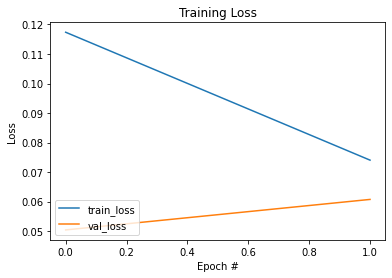

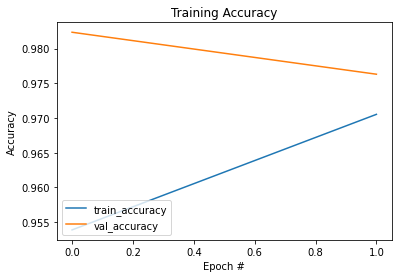

In [13]:
N = range(0, 2)
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.figure()
plt.plot(N, history.history["accuracy"], label="train_accuracy")
plt.plot(N, history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Save the model

In [0]:
model.save('cnn_transfer_learning.h5')

# Evaluate the model

In [15]:
test_loss, test_acc = model.evaluate(validation_generator, steps=2000//64)
print('Accuracy on Validation Set:', test_acc)

31/31 [==============================] - 9s 293ms/step - loss: 0.0608 - accuracy: 0.9763
Accuracy on Validation Set: 0.9763104915618896


# Unfreeze and train more

In [0]:
n_layers = len(base_model.layers)

In [17]:
n_layers

311

In [0]:
for layer in model.layers[:n_layers - 10]:
   layer.trainable = False
for layer in model.layers[n_layers - 10:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='binary_crossentropy', metrics=["accuracy"])

In [22]:
model.fit(train_generator, 
          steps_per_epoch=23000//64, 
          epochs=2, 
          validation_data=validation_generator, 
          validation_steps=2000//64)

Epoch 1/2
359/359 [==============================] - 344s 959ms/step - loss: 0.0679 - accuracy: 0.9724 - val_loss: 0.0499 - val_accuracy: 0.9808
Epoch 2/2
359/359 [==============================] - 341s 950ms/step - loss: 0.0661 - accuracy: 0.9740 - val_loss: 0.0484 - val_accuracy: 0.9819


In [23]:
test_loss, test_acc = model.evaluate(validation_generator, steps=2000//64)
print('Accuracy on Validation Set:', test_acc)

31/31 [==============================] - 9s 289ms/step - loss: 0.0485 - accuracy: 0.9819
Accuracy on Validation Set: 0.9818548560142517
